# Crefit default prediction with machine learning

This notebook implements some modeling for modeling credit defaults on an open Czech bank dataset.
This small portfolio project was inspired by an experiment found here:
https://blog.boogiesoftware.com/2019/01/credit-risk-profiling-using-open-bank.html
I use the same target variable, but generate my own set of features.
The implementation here outperforms the results in the blog posts.

The work currently only uses a logistic regression and a gradient boosting implementation.
I am currently working on an improved solution with automated feature engineering and ensembling different models.

In [244]:
#Import modules
import pandas as pd
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, learning_curve, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, brier_score_loss, accuracy_score
import bk_plot as bp

## Data generation, import and missing values

We first generate features and target variables for prediction by running the data generation script.
We use aggregations of transactions for the latest 3000 days (full history excluding the latest 60 days), and the latest 60 days prior to the loan date. These time horizons can be passed to the script as arguments and adjusted as you like.

In [ ]:
#script to download and unzip data
#!data_download.bat

#Python script for data prep
#!ipython credit_risk_datagen.py 3000 60

#open the pickled dataset generated by the script
with open('loan_data', 'rb') as file:
    loans = pickle.load(file, encoding="latin1")

In [ ]:
#Missing observations
print('Missing observations')
print(loans.isna().sum()[loans.isna().sum() > 0])
print('\nTotal loans: ', len(loans))
print('Total cases with missing data: ', loans.isna().sum(axis=1).sum())
print(round(100*loans.isna().sum(axis=1).sum()/len(loans), 2),'% of total cases.')
print('Loans behind in payment with missing data: ', (loans[loans.isna().sum(axis=1).astype(bool)].target == 1).sum())
print('Total number of loans behind in payment: ', loans.target.sum())
print('Account age of loan with missing rate_max: ', loans[loans.rate_max.isna()].accnt_age.values[0])
print('Minimum age of loans: ', min(loans.accnt_age))
loans['rate_max'] = loans.rate_max.fillna(loans.rate_max_short)
loans['rate_min'] = loans.rate_min.fillna(loans.rate_min_short)
loans['rate_mean'] = loans.rate_mean.fillna(loans.rate_mean_short)

The missing applicant data is from the earliest part of the data. We will drop the applicants column for now. Additionally observation for historical (longer term) rates is missing. The account associated has not been granted interest payments 60 days prior to loan issuance. We will replace the NA with the 2 month value.

We generate the final feature matrix X and target vector y. We drop the applicants column with missing data. To be certain that model performance is not affected, we also drop the demographic data, which might not be ex-ante observable.

We do some hyperparameter tuning and feature selection, which can cause some overfit on the training data even when using cross-validation. Because of this we leave some hold-out data to serve as a test of how well the models generalize.

In [ ]:
X = loans.drop(['applicants','A4', 'A5', 'A6', 'A7', 'A8', 'A9',
       'A10', 'A11', 'A12', 'A13', 'A14'], axis=1)
y = X.target
X.drop(['target'], axis=1, inplace=True)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

## Baseline linear model

We will begin with a baseline logistic regression models with the kitchen sink approach, using all generated features for prediction. As we have a large amount of features, we use the L1 (Lasso) regularization that can shrink coefficients to zero, rather than the default L2 (Ridge) regularization.

In addition I standardize the features. Standardizing helps the regression algorithm to converge and makes for easier interpretation of the coefficients as all are at the same scale.

Because there are relatively few loans that default, accuracy is not an ideal metric of model performance. Furthermore, because predictions are of interest in evaluating credit risk and setting loan rates, the predicted probability has a meaningful interpretation. I complement the prediction accuracy with the brier score which measures the mean squared difference between the predicted probability assigned to the problems in loan repayment and the actual outcome. The lower the brier score loss is, the better.

Because there is a time-series element to the data, ideally we would want to use a time-series split for cross-validation to make sure ex-post information does not affect model performance. However, because we have little data and the time-seriesness of the data is not likely to be a major concern, we will settle with 10-fold cross-validation.

We also generate the accuracy for the naive prediction that all loans complete succesfully. For the brier score loss we generate the benchmark loss for the naive prediction that the probability of a default is the same (sample mean) across all observations.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
    
class CustomScaler(BaseEstimator,TransformerMixin): 
    """
    Custom wrapper for the StandardScaler that does not scale
    dummy variables. This makes for more interpretable coefficients.
    
    """
    def __init__(self,columns):
        self.scaler = StandardScaler()
        self.columns = columns

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        if len(self.columns)>0:
            self.scaler.fit(X.iloc[:,self.columns], y)
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        mask = [i for i in range(len(X.columns)) if i not in self.columns]
        X_dummy = X.iloc[:,mask]
        if len(self.columns)>0:
            X_cont = pd.DataFrame(self.scaler.transform(X.iloc[:,self.columns]),
                                  columns=self.columns, index=X.index)
            frame = pd.concat([X_dummy, X_cont], axis=1)
        else:
            frame = X
        return frame

class PipelineRFE(Pipeline):
        """
        Wrapper class for pipeline. Captures the coefficients or feature importances
        from the pipeline.
        """
        def fit(self, X, y=None, **fit_params):
            self.steps[0][1].columns = \
                [i for i, x in enumerate((np.amin(X, axis=0)!=0)|(np.amax(X, axis=0)!=1)) if x]
            super(PipelineRFE, self).fit(X, y, **fit_params)
            clf = self.steps[-1][-1]
            if hasattr(clf, 'coef_'):
                self.coef_ = clf.coef_
            else:
                self.feature_importances_ = clf.feature_importances_
            return self

def create_pipeline(classifier, dummies=None):
    """
    Function to automatically generate a pipeline to fit with standard scaler
    """
    pipe =  [
        ('std_scaler', CustomScaler(dummies)),
        ('clf', classifier)
    ]  
    return(PipelineRFE(pipe))

#mask for the dummy variables
dummy_mask = [i for i, x in enumerate((X.max() != 1)|(X.min() != 0)) if x]

#crossvalidation object and scorer to be used for model fitting
kfold = StratifiedKFold(n_splits=10)
scorer = make_scorer(brier_score_loss, needs_proba=True)

#benchmark naive predictions
benchmark_acc = 1-np.mean(y)
benchmark_brier = brier_score_loss(y, np.repeat(np.mean(y), len(y)))

In [ ]:
#Train initial baseline model

logr_params = {'C':0.85, 'class_weight':None, 'penalty': 'l1'}
logc = create_pipeline(LogisticRegression(**logr_params, solver='liblinear'), dummy_mask)

g, bm_lin_acc = bp.plot_learning_curve(logc,"Logistic regression learning curves",X, y,cv=kfold, ylim=(0.85, 1),
                        train_sizes=np.linspace(.3, 1.0, 7), benchmark = benchmark_acc)
g, bm_brier = bp.plot_learning_curve(logc,"Logistic regression learning curves",X, y,cv=kfold, ylim=(0.0, 0.1),
                        train_sizes=np.linspace(.3, 1.0, 7), benchmark = benchmark_brier,
                       scoring = scorer)

### Model coefficients

In [ ]:
#refit the final model using the full dataset to capture coefficients
logc.fit(X, y)
print('Accuracy on hold-out data: ', accuracy_score(y_test, logc.predict(X_test)))
print('Brier score loss on hold-out data: ', brier_score_loss(y_test, logc.predict(X_test)))


coef_plot, coef = bp.fit_importances(logc, X, y, 'Logistic Regression Coefficients')

27 features end up having non-zero coefficients in the logistic regression model with 94% accuracy and 0.058 brier loss on the hold-out data. The model seems to generalize well and provides a good benchmark for the gradient boosting.

The suffix _short means that the variable is aggregated from transactions over the last 60-days prior to loan issuance. Aggregations without the suffix are computed from the full transaction history without 

The loan specific-variables loan duration, loan payments and loan amount seem to be some of the most important predictor variables in terms of coefficient size. Aggregations of account balances prior to loan issuance and the rate variables also play a role. The rate variables are computed from the account balance and interest payments credited to the account. Because the interest is paid with a lag and actual interest rates should be similar across accounts, they likely proxy for recent fluctuations in the account balance.

There are a lot of coefficients and the predictor variables are highly correlated at times. Because of this there is a lot of interplay between the coefficients and interpreting individual coefficients is difficult and unmeaningful at times. Note that this multicollinearity should not affect model performance, however, especially as the training is validated using hold-out data.

## Gradient Boosting Model

We train a gradient boosting model with the full set of features.

It turns out that the linear model performs very well on this small dataset and is quite difficult to beat.
With some hyperparameter search, we achieve quite similar performance, than the linear model.
Note that the hyperparameter search might cause some overfit on the training sample. Again, the holdout test data provides some guidance as to whether were overfitting.
The hyperparameter tuning below runs for a while. For convenience, tuned parameters are available below.

In [ ]:
"""
#grid of parameters to search from
gbc_param_grid = {'clf__subsample': [1],
 'clf__n_estimators': [100, 200, 300, 400],
 'clf__min_samples_leaf': [0.01 ,0.03, 0.05],
 'clf__max_features': [4,5,6],
 'clf__max_depth': [3],
 'clf__loss': ['exponential', 'deviance'],
 'clf__learning_rate': np.linspace(0.03, 0.15, 5)}

#initiate the gridsearch object
gbc_search = GridSearchCV(create_pipeline(GradientBoostingClassifier(), dummy_mask),
                   gbc_param_grid, cv=kfold, scoring='neg_log_loss', n_jobs=3)
#fit and collect best parameters
gbc_search.fit(X, y)
gbc_tuned_params = gbc_search.best_params_
"""

Pre-tuned parameters

In [ ]:
gbc_tuned_params = {'learning_rate': 0.06,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 4,
 'min_samples_leaf': 0.01,
 'n_estimators': 100,
 'subsample': 1}


In [ ]:
#initiate the model with the tuned parameters
gbc = create_pipeline(GradientBoostingClassifier(**gbc_tuned_params), dummy_mask)

#train and plot learning curves                      
g, gb_bm_acc = bp.plot_learning_curve(gbc,"Gradient Boosting learning curves",X, y, cv=kfold,
                        train_sizes=np.linspace(.3, 1.0, 7), benchmark = bm_lin_acc)
g, gb_bm_brier = bp.plot_learning_curve(gbc,"Gradient Boosting learning curves",X, y, cv=kfold,
                        train_sizes=np.linspace(.3, 1.0, 7), benchmark = bm_brier,
                       scoring = scorer)

In [ ]:
#refit the final model using the full dataset to capture coefficients
gbc.fit(X, y)
print('Accuracy on hold-out data: ', accuracy_score(y_test, gbc.predict(X_test)))
print('Brier score loss on hold-out data: ', brier_score_loss(y_test, gbc.predict(X_test)))


imortance_plot, _ = bp.fit_importances(gbc, X, y, 'Gradient Boosting Feature Importances')

We get some improvement over the baseline linear model. With accuracy improving from 94.2% to 94.7% and brier score improving from 0.585 to 0.526.
The hyperparameter search does not seem to induce overfit.

# Deep feature synthesis

We first generate two data sets, a monthly set of transactions and a set of static data for the loans.

The final dataset will consist of features automatically engineered from these datasets.
We run three different transformations: addition, multiplication and division for the loans data for different aggregations of the monthly transactions data. 
Each of these aggregation operations results in a large amount of generated features. We will then run a process of selecting variables.

In [ ]:
import featuretools as ft

!python dfs_prep.py

with open('dfs_data_loans', 'rb') as file:
    loans_dfs = pickle.load(file, encoding="latin1")

with open('dfs_data_trans', 'rb') as file:
    trans_dfs = pickle.load(file, encoding="latin1")

In [ ]:
loans_dfs = loans_dfs.drop('target', axis=1)
trans_dfs.reset_index(inplace=True)

In [ ]:

def get_good_features(feature_matrix, x_ind, x_t_ind, reg_params = logr_params):
    """
    Takes in as arguments a generated feature matrix and
    indices of train and test data. Fits a logistic regression
    with L1 regularization on the train sample and returns 
    a feature matrix of features with non-zero coefficients
    with train and test data stacked.
    """
    #drop features with nas and features with 0 variance
    feature_matrix = feature_matrix.loc[:,(feature_matrix.isna().sum() == 0)]
    feature_matrix = feature_matrix.loc[:,(feature_matrix.var() > 0)]
    
    #separate dummy and test data
    X_m = mult_feature_matrix.loc[x_ind,:]
    X_m_test = mult_feature_matrix.loc[x_t_ind,:]
    
    #mask for the dummy variables
    dummy = [i for i, x in enumerate((X_m.max() != 1)|(X_m.min() != 0)) if x]
    #create and fit log regression
    test_model = create_pipeline(LogisticRegression(**reg_params, solver='liblinear'), dummy)
    test_model.fit(X_m, y)
    
    
    X_m = X_m.loc[:,(test_model.coef_[0] != 0)]
    X_m_test = X_m_test.loc[:,(test_model.coef_[0] != 0)]
    return X_m.append(X_m_test)

def run_generation(es, target_ent, agg_prims, trans_prims,
                  x_ind, x_t_ind, reg_params = logr_params, n_job = 4):
    """
    Automated feature generation with prespecified
    arguments.
    es = pre-constructed entityset
    target_ent = name of target entity to aggregate down to
    agg_prims = list of aggregation primitives to be used
    trans_prims = list of transformation primitives,
                each to be run separately
    x_ind = indices of train data
    x_t_ind = indices of test data
    reg_params = parameters for the logistic regression
    n_job = n_jobs for the deep feature synthesis
    Returns two feature matrices, one for the training data
    and one for the test data.
    """
    final_feat = pd.DataFrame(index=x_ind.append(x_t_ind))
    #run each transformation separately
    for transform in trans_prims:
        fm, _ = ft.dfs(entityset=es,
                       target_entity = target_ent,
                       agg_primitives = agg_prims,
                       trans_primitives = [transform],
                       max_depth = 2, 
                       verbose = 1, 
                       n_jobs = n_job)
        #limit features
        fm = get_good_features(fm, x_ind, x_t_ind, reg_params)
        
        final_feat = pd.merge(final_feat, fm, suffixes=('',transform),
                             left_index=True, right_index=True)
    #limit features of the full set    
    final_feat = get_good_features(final_feat, x_ind, x_t_ind, reg_params)
    final_feat = final_feat.T.drop_duplicates().T
    #separate train and test data
    final = final_feat.loc[x_ind,:]
    final_test = final_feat.loc[x_t_ind,:]
    return final, final_test

## Create entityset and generate features

In [ ]:
es = ft.EntitySet(id = 'loan')
es.entity_from_dataframe(entity_id = 'loan', dataframe = loans_dfs, index='loan_id')
es.entity_from_dataframe(entity_id='trans',
                                 dataframe=trans_dfs,
                                 index='index',
                                 time_index='month')
rl = ft.Relationship(es['loan']['loan_id'],
                                    es['trans']['loan_id'])

# Add the relationship to the entity set
es = es.add_relationship(rl)

In [ ]:
params = {'C':0.85, 'class_weight':None, 'penalty': 'l1'}
X_dfs, X_dfs_test = run_generation(es, 'loan', ['min','mean','max'],
                                  ['multiply_numeric', 'divide_numeric', 'add_numeric'],
                                    X.index, X_test.index, params)

In [ ]:
mask = [i for i, x in enumerate((X_dfs.max() != 1)|(X_dfs_test.min() != 0)) if x]
gbc_tuned_params = {'learning_rate': 0.06,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 4,
 'min_samples_leaf': 0.01,
 'n_estimators': 100,
 'subsample': 1}

#initiate the model with the tuned parameters
gbc = create_pipeline(GradientBoostingClassifier(**gbc_tuned_params), mask)

#train and plot learning curves                      
g, _ = bp.plot_learning_curve(gbc,"Gradient Boosting learning curves",X_dfs, y, cv=kfold,
                        train_sizes=np.linspace(.3, 1.0, 7), benchmark = gb_bm_acc)
g, _ = bp.plot_learning_curve(gbc,"Gradient Boosting learning curves",X_dfs, y, cv=kfold,
                        train_sizes=np.linspace(.3, 1.0, 7), benchmark = gb_bm_brier,
                       scoring = scorer)

Accuracy on hold-out data:  0.9532163742690059
Brier score loss on hold-out data:  0.04678362573099415


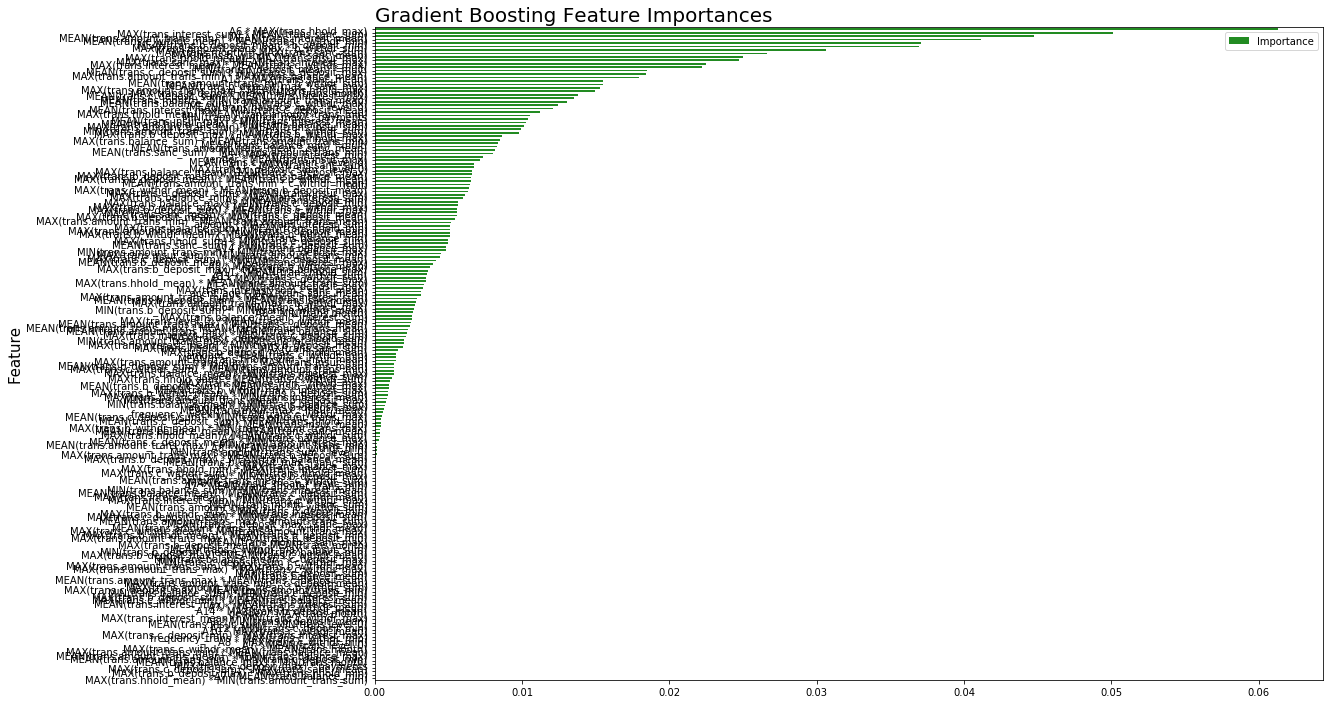

In [243]:
#refit the final model using the full dataset to capture coefficients
gbc.fit(X_dfs, y)
print('Accuracy on hold-out data: ', accuracy_score(y_test, gbc.predict(X_dfs_test)))
print('Brier score loss on hold-out data: ', brier_score_loss(y_test, gbc.predict(X_dfs_test)))


imortance_plot, _ = bp.fit_importances(gbc, X_dfs, y, 'Gradient Boosting Feature Importances')